### Project Goal


You are working for an e-commerce company. The company wants to optimize the conversion
rate for its website. Conversion refers to the action the company wants the user to take, which
in this case is making a purchase. The conversion rate is simply the number of conversions
divided by the total number of visitors the page receives.

We have data about users who hit our site. We know whether they converted or not, as well as
some of their basic characteristics such as the country they’re in, the marketing channel that
brought them to the site, their age, whether they are repeat users, and the number of pages
visited during that session (as a proxy for site activity/time spent on the site).

Your project is to:
1. Perform Exploratory Data Analysis and produce 2-3 plots that show either important
features or interesting patterns in the data. It is up to you what you want to highlight.
2. Build a model to predict conversion rate and critically evaluate it, explaining your choice
of model and performance metric.
3. Come up with recommendations for the product team and the marketing team to
improve conversion rate.

# Part 0 Load packages, load data

In [0]:
#import neccessary libraries
import numpy as np
import pandas as pd
import sklearn as sl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x)   
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)

In [0]:
# method 1 install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1Q2BnerNIndvFr3tGEh5XkTtUOIP1yF45'
fluff, id = link.split('=')
file = drive.CreateFile({'id':'1Q2BnerNIndvFr3tGEh5XkTtUOIP1yF45'}) # replace the id with id of file you want to access
file.GetContentFile('conversion_data.csv')  

In [4]:
df = pd.read_csv('conversion_data.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


# Part 1: Data Exploration

### 1.1. Understand the raw dataset

In [9]:
print ("Num of rows: " + str(df.shape[0])) # row count
print ("Num of columns: " + str(df.shape[1])) # col count

Num of rows: 316200
Num of columns: 6


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [10]:
# check the unique values for each column
df.nunique()

country                 4
age                    60
new_user                2
source                  3
total_pages_visited    29
converted               2
dtype: int64

In [0]:
# Get target variable
y = df['converted']

In [12]:
# check conversion rate
print('conversion rate' + str(y.sum() / y.shape * 100))    #imbalance data

conversion rate[3.22580645]


### 1.2.  Understand the features

In [13]:
# check missing values
df.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [14]:
# understand Numerical feature
df[['age', 'total_pages_visited']].describe()

,age,total_pages_visited
count,316200.000,316200.000
mean,30.570,4.873
std,8.272,3.341
min,17.000,1.000
25%,24.000,2.000
50%,30.000,4.000
75%,36.000,7.000
max,123.000,29.000


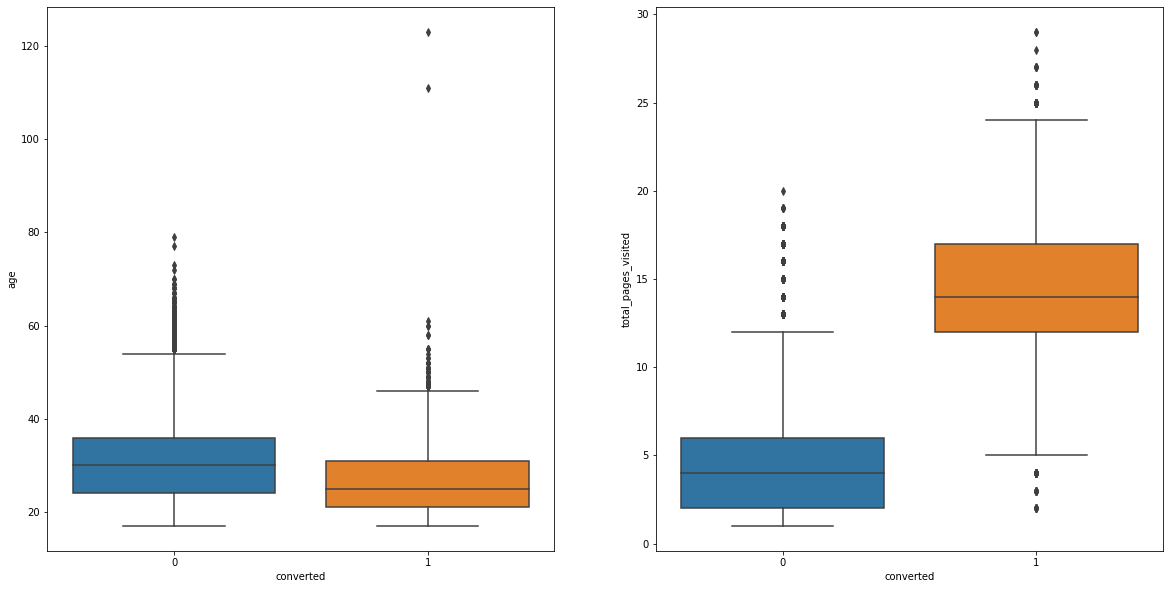

In [24]:
# boxplot for numerical feature
_,axss = plt.subplots(1,2, figsize=[20,10])
sns.boxplot(x='converted', y ='age', data=df, ax=axss[0])
sns.boxplot(x='converted', y ='total_pages_visited', data=df, ax=axss[1])

Insights: 
1. The youger the person, the more likely he/she will make purchases.
2. The more pages a person visited during the session, the more likely he/she will buy.



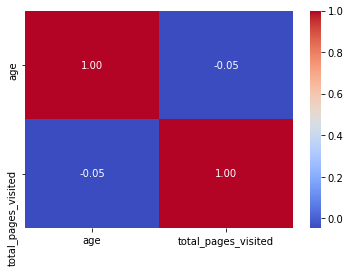

In [29]:
# Correlation among numerical features
corr = df[['age', 'total_pages_visited']].corr()

# show heapmap of correlations
sns.heatmap(corr, annot=True, fmt = ".2f", cmap = "coolwarm")

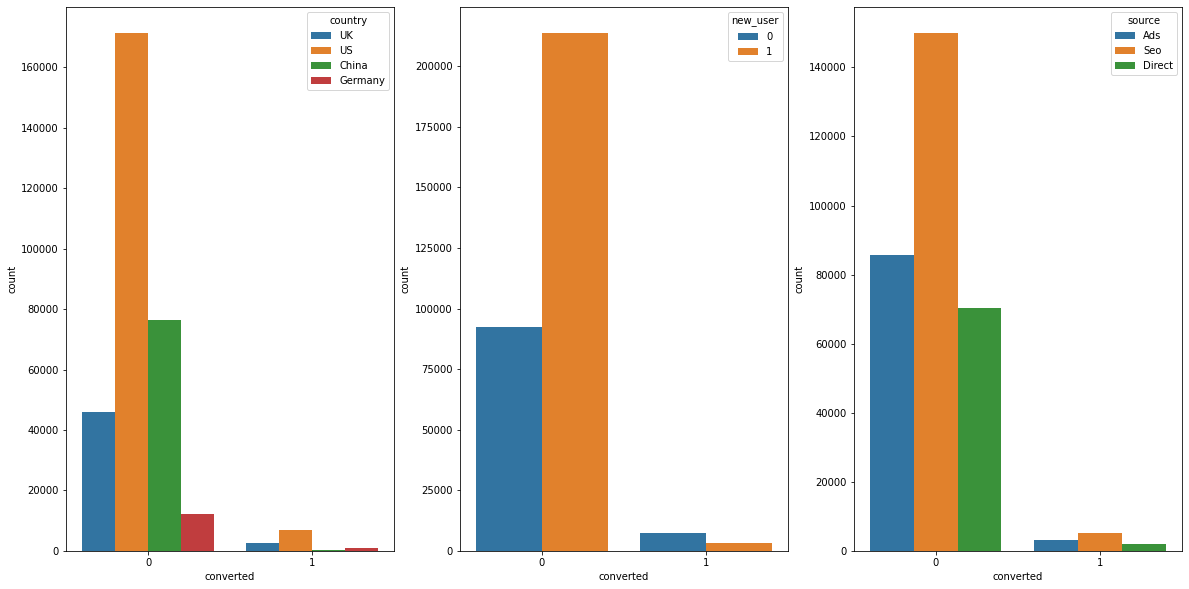

In [26]:
# understand categorical feature
_,axss = plt.subplots(1,3, figsize=[20,10])
sns.countplot(x='converted', hue='country', data=df, ax=axss[0])
sns.countplot(x='converted', hue='new_user', data=df, ax=axss[1])
sns.countplot(x='converted', hue='source', data=df, ax=axss[2])

Insights:
1. Most customers are from the US. Costomers from China has the lowest conversion.
2. New users have low conversion compared to returned users.
3. Most customers came to the sight by clicking on search results. It seems the website has good ranking in search engine.  

# Part 2: Feature Preprocessing

In [0]:
# one hot encoding
df = pd.get_dummies(df, columns=['country','new_user','source'],drop_first = True)  #drop_first to avoid collinearity


In [33]:
df.head()

,age,total_pages_visited,converted,country_Germany,country_UK,country_US,new_user_1,source_Direct,source_Seo
0,25,1,0,0,1,0,1,0,0
1,23,5,0,0,0,1,1,0,1
2,28,4,0,0,0,1,1,0,1
3,39,5,0,0,0,0,1,0,1
4,30,6,0,0,0,1,1,0,1


In [0]:
# Get feature space 
X = df.drop('converted', axis=1)

# Part 3: Model Training and Result Evaluation

### 3.1. Split dataset

In [38]:
# Reserve 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 252960 observation with 8 features
test data has 63240 observation with 8 features


In [0]:
# Scale the data, using standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 3.2. Model Training and Selection

This is a classification problem, as we want to predict whether the person made the purchase or not during the session. I will build three classic classification models-- logistic regression, RNN, and Random Forest-- and evaluate the model performace based on accuracy score and AUC score. 

Because we are interested in converting those who did not purchase, we focus on prediction accuracy. AUC score is my second metric to consider as it measures how good the model ranks predictions.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

3.2.1 Logistic Regression

In [54]:
# fit the model with data
classifier_logistic.fit(X_train, y_train)
pred = classifier_logistic.predict(X_test)

# model evaluation
print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))

y_pred_proba = classifier_logistic.predict_proba(X_test)[::,1]
print("ROC score:",metrics.roc_auc_score(y_test, y_pred_proba))


Accuracy: 0.9853731815306768
Precision: 0.8516247700797057
Recall: 0.6703667953667953
ROC score: 0.9845979720577142


In [58]:
classifier_logistic.coef_[0]
print ("Logistic Regression Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), classifier_logistic.coef_[0]), \
                      X.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))

Logistic Regression Coefficients
total_pages_visited: 2.5444
country_US: 1.6213
country_UK: 1.314
new_user_1: -0.8021
country_Germany: 0.7642
age: -0.6239
source_Direct: -0.0814
source_Seo: -0.0279


3.2.2 KNN

In [55]:
# fit the model with data
classifier_KNN.fit(X_train, y_train)
pred = classifier_KNN.predict(X_test)

# model evaluation
print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))

y_pred_proba = classifier_KNN.predict_proba(X_test)[::,1]
print("ROC score:",metrics.roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.9841397849462366
Precision: 0.8145968216597999
Recall: 0.667953667953668
ROC score: 0.9135575374662805


3.2.3 Random Forest

In [56]:
# fit the model with data
classifier_RF.fit(X_train, y_train)
pred = classifier_RF.predict(X_test)

# model evaluation
print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))

y_pred_proba = classifier_RF.predict_proba(X_test)[::,1]
print("ROC score:",metrics.roc_auc_score(y_test, y_pred_proba))


Accuracy: 0.9843769765970904
Precision: 0.8191990577149588
Recall: 0.6713320463320464
ROC score: 0.9443120194575203


In [57]:
importances = classifier_RF.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), X.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
total_pages_visited: 0.8144
age: 0.1038
new_user_1: 0.0379
country_US: 0.0132
country_UK: 0.0124
country_Germany: 0.0091
source_Seo: 0.0049
source_Direct: 0.0041


Insights:

Logistic regression gives me the highest accuracy score (0.985) as well as highest AUC score (0.985). It is also easier to train and interpret. Therefore, I will choose logistic regression as my final model.

Logistic regression model shows that the top important factor affecting conversion are number of pages visited during the session (+) ,whether he/she is browsing from the US (+), or from UK (+), and whether he/she is a new user (-)

Our model sugguests that we can target new users to improve conversion rate. Most importantlt,we need to improve website to increase page visits, such as more similar product recommendation links to increase clicks, etc.


### 3.3. Grid Search to Find Optimal Hyperparameters 



In [0]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [61]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

# ('l1', 1) ('l1', 5) ('l1', 10) ('l2', 1) ('l2', 5) ('l2', 10)
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.9863259013282732
Best parameters set:
C:1
penalty:l1
